# 61 — Deep Residual Learning in Spiking Neural Networks
https://arxiv.org/abs/2102.04159 

The goal of this notebook is to explain Spiking Neural Networks and how you can use residual learning to train deep SNNs.

<div class="warning">
You should use Google Colab **with a GPU** to run this notebook, unless you have Cupy, CUDA and a GPU with more than 14GB of VRAM. Python 3.8 is highly recommended
</div>

Color code:
<div class="alert alert-success">Key results in green boxes</div>
<div class="alert alert-warning">Exercices in yellow boxes</div>
<div class="alert alert-danger">Solutions in red boxes</div>


First let's install a library implementing SNNs in python, the one used in the paper cited above.
<!-- <a ref="https://spikingjelly.readthedocs.io/zh_CN/0.0.0.0.12">  -->
SpikingJelly documentation:
<!-- </a>  -->
https://spikingjelly.readthedocs.io/zh_CN/0.0.0.0.12/#index-en 

<div class="alert alert-success">Run this code if you want to be reminded to skip to the Deep residual learning after 40minutes.
<br>The first part is an introduction to SNNs and building CNNs with them, you do not need to understand it all to understand the Deep residual learning part.
<br>Or just set yourself a timer of 40 minutes to skipping to the Deep residual learning!</div>


In [144]:
from IPython.display import display, Javascript

javascript = """
setTimeout(function() {
  // Code to be executed after 40 minutes
  alert("You should skip to the Deep Residual Learning part");
}, 40 * 60 * 1000);
"""

display(Javascript(javascript))


<IPython.core.display.Javascript object>

In [ ]:
# this is a library implementing SNNs in python. 
!pip install spikingjelly==0.0.0.0.12

In [7]:
# install Cupy if you have CUDA (not needed in Colab)
# you should follow the tutorial https://docs.cupy.dev/en/stable/install.html
# to install with the precompiled wheels

# !pip install cupy-cuda12x # if you have cuda v12.x

In [2]:
# Cupy is the computation backend used by spiking jelly. 
# It's like numpy but runs on GPUs. 
# The fallback backend for spiking jelly is torch. It's VERY slow for large SNNs
try: 
    import cupy
    snn_backend = "cupy"
except ImportError:
    snn_backend = "torch"
print("using spikingjelly backend:", snn_backend)

from pathlib import Path
import matplotlib.pyplot as plt
import os
import time
import argparse
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms

from spikingjelly.clock_driven import neuron, functional, surrogate, layer
from spikingjelly import visualizing

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"using device {DEVICE} for pytorch") # MPS is for macOS with ARM (apple silicon) processors

data_folder = Path("./data")


using spikingjelly backend: torch
using device mps for pytorch


## An introduction to Spiking Neural Networks, *SNNs*

SNNs are different in many ways from ANNs which are fully-connected and use continuous values. Although ANNs are biologically inspired and helped us made breakthroughs, they are biologically inn-accurate and do not mimic our brains' neurons.
<br>
<br>
**Nature came up with SNNs**, a versatile solution to fault-tolerant and energy efficient signal processing in our brains.
Therefore, taking inspiration from the brain is a natural approach to engineering more efficient computing architectures.
<br>
<h4>How can we use SNNs to build neural networks? And what is a spiking neuron?</h4>


<!-- 
This is what SNNs are here for: use bio-realistic models of neurons.



These are generally fully connected, take in continuous values, and output continuous values -->

<a title="Harrypotterrrrr, CC BY-SA 4.0 &lt;https://creativecommons.org/licenses/by-sa/4.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Simplified_diagram_of_a_typical_biological_neural_cell_showing_a_basic_neuromorphic_unit_and_working_mechanism_diagram.png">
<img alt="Simplified diagram of a typical biological neural cell showing a basic neuromorphic unit and working mechanism diagram" src="https://upload.wikimedia.org/wikipedia/commons/5/58/Simplified_diagram_of_a_typical_biological_neural_cell_showing_a_basic_neuromorphic_unit_and_working_mechanism_diagram.png">
</a>

Here is a simplified diagram of a typical biological neural cell showing a basic neuromorphic unit and working mechanism diagram.
<br>
(A) Simplified diagram of a typical biological neural cell
<br>
(B) A spiking neural cell modeled as a basic neuromorphic unit.
<br><br>
(C) Working mechanism of a typical **integrate and firing neuron, which we will use in our SNNs**. Resistive synapses convert voltage spikes into currents proportional to their synaptic weights.
<br>
The neuron integrates these current inputs $V_{spk,in}$ injected by the previous neurons to change the membrane voltage $V_{mem}$. Once $V_{mem}$ crosses a firing threshold $V_{thr}$, the neuron fires and sends a spike $V_{spk}$ to the next neuron.

<h4>To sum up:</h4>
SNNs operate using spikes, which are discrete events that take place at points in time, rather than continuous values. The occurrence of a spike is determined by differential equations that represent various biological processes, the most important of which is the <b>membrane potential of the neuron</b>.

<h4>There are three equations to describe an Integrate and Fire (IF) neuron:</h4>

- <b>Membrane potential:</b>
<br>Leaky Integrate and Fire (LIF):
<br>$\frac{dV}{dt} = \frac{1}{\tau_m} * (-(V-V_{rest}) + R_m * I)$
<br>Where **$V$ is the membrane potential, $I$ is the input current**, ${\tau_m}$ is the membrane time constant, $V_{rest}$ is the resting potential, and $R_m$ is the membrane resistance.
<br><br>
If we take $R_m, {\tau_m} = 1$ and neglect the leaky part $V - V_{rest}$, **we have the Integrate and Fire neuron** (not leaky) described in the paper we're explaining in this notebook:
<br><b>$V[t] = V[t-1] + I[t]$</b>
<br><br>
- <b>Output spike $S[t]$:</b>
<br>If the neuron's membrane potential is over the threshold, the neuron outputs a spike S.
<br>$S[t] = \Theta(V[t] - V_{th})$
<br>Where $\Theta$ is the Heaviside function: $S[t] = \begin{cases}
1 & \text{if } V[t] \geq V_{th} \\
0 & \text{otherwise}
\end{cases}$
<br><br>
- <b>Resetting process</b>, also called hard reset in spikingjelly:
<br>When there is a spike, i.e. $S[t]=1$ the neuron's potential is reset to $V_{reset}$.
<br>$V[t] = \begin{cases}
V_{reset} & \text{if } S[t] = 1 \\
V[t] & \text{if } S[t] = 0
\end{cases}$


<!-- <br>Where $\Theta$ is the Heaviside function: $S[t]=1 if V[t]>=V_th else 0 -->


<!-- <br>$\Delta_t(V) = X[t], \ \ \text{with} \ \ \Delta_t(V[t]) = V[t] - V[t-1]$
<br>it can be written as $V[t] = V[t-1] + X[t]$ with X the input current.  -->

<img src="https://miro.medium.com/max/1100/1*vvjGQAfTlk2NPD7bmD1zVQ.gif" alt="leaky integrate and fire neuron"/>
<br>Here is an animation of a Leaky IF's membrane potential behavior during a spike

<img src="./img/Potential of a LIF neuron.png">
From Neftci, E. O., Mostafa, H., & Zenke, F. (2019). Surrogate Gradient Learning in Spiking Neural Networks: Bringing the Power of Gradient-based optimization to spiking neural networks. IEEE Signal Processing Magazine, 36, 51-63.


The image above shows how a LIF neuron will output spikes depending on its membrane potential when exited by the four input neurons, in a time simulation

Now that we know how a spiking neuron works, let's try using them!

### First steps with spiking neurons

We will use a Leaky Integrate and Fire neuron and play with its parameters.

LIFNode(
  v_threshold=1.0, v_reset=0.0, detach_reset=False, tau=30.0
  (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
)


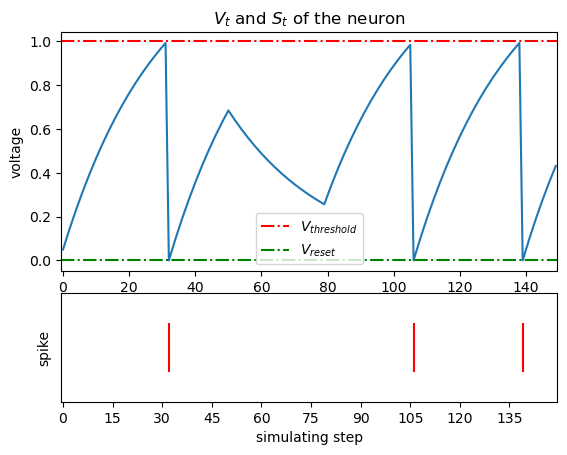

In [53]:
lif_neuron = neuron.LIFNode(tau=30.0, v_reset=0., v_threshold=1.)

print(lif_neuron)
lif_neuron.reset() # reset potential

input_current = float(1.5)
x = torch.as_tensor([input_current])

no_input = torch.as_tensor([0])

T = 150
s_list = []
v_list = []
for t in range(T):
    if t > 50 and t < 80:
        s_list.append(lif_neuron(no_input))
        v_list.append(lif_neuron.v)
    else:
        s_list.append(lif_neuron(x))
        v_list.append(lif_neuron.v)

s_list = np.array([np.array(i) for i in s_list]).squeeze()
v_list = np.array([np.array(i) for i in v_list]).squeeze()

visualizing.plot_one_neuron_v_s(
    v_list,
    s_list,
    v_threshold=lif_neuron.v_threshold,
    v_reset=lif_neuron.v_reset,
    dpi=100,
)
plt.show()


What happens when you change the threshold or the input current? And what happens in the middle?

<details>
  <summary>Click to show/hide the answer</summary>
  
  - When you decrease $\tau$ the neuron is faster, thus it will fire more spikes!

  - When you increase the input current the neuron gets exited faster and will also fire more spikes

  - In the middle the neuron is not exited. As it is a leaky its membrane potential decreases.
</details>


Can you do the same thing for a IF neuron, not leaky? Can you find an input current to have similar results?

IFNode(
  v_threshold=1.0, v_reset=0.0, detach_reset=False
  (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
)


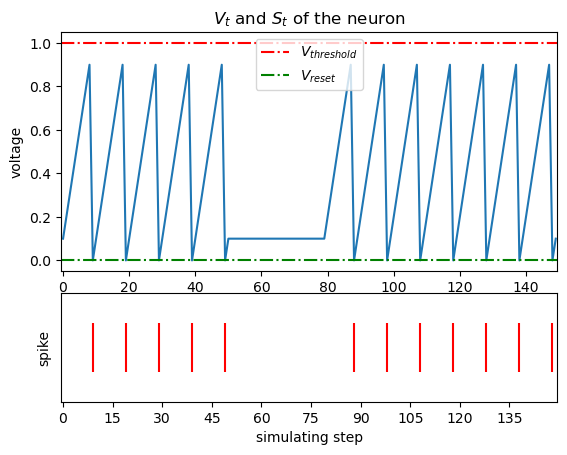

In [54]:
if_neuron = neuron.IFNode(v_reset=0., v_threshold=1.)

print(if_neuron)
if_neuron.reset() # reset membrane potential

# put your input current here
input_current = float(??)

x = torch.as_tensor([input_current])

no_input = torch.as_tensor([0])

T = 150
s_list = []
v_list = []
for t in range(T):
    if t > 50 and t < 80:
        s_list.append(if_neuron(no_input))
        v_list.append(if_neuron.v)
    else:
        s_list.append(if_neuron(x))
        v_list.append(if_neuron.v)

s_list = np.array([np.array(i) for i in s_list]).squeeze()
v_list = np.array([np.array(i) for i in v_list]).squeeze()

visualizing.plot_one_neuron_v_s(
    v_list,
    s_list,
    v_threshold=if_neuron.v_threshold,
    v_reset=if_neuron.v_reset,
    dpi=100,
)
plt.show()


As this neuron is not leaky, you guessed it, an input current over the threshold would always fire. An input current of 0.1 is a good choice.

Bellow you can visualize multiple neurons potentials when the input current is different for each. 

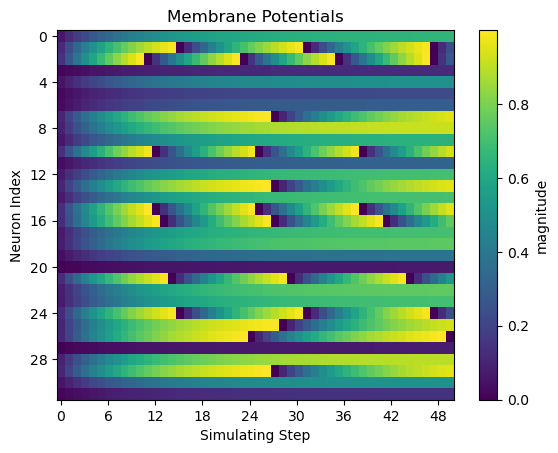

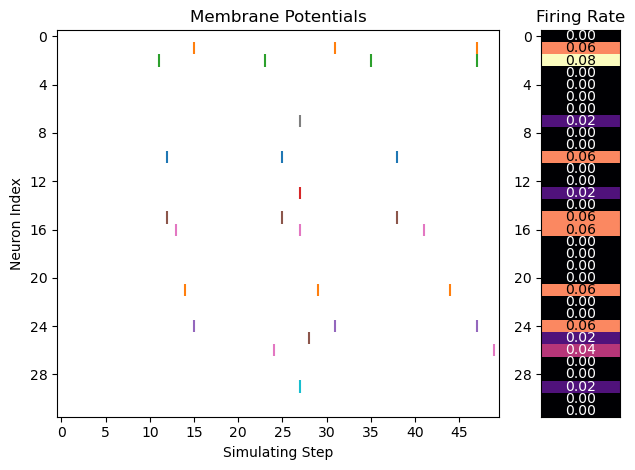

In [67]:
lif = neuron.LIFNode(tau=10.)

lif.reset()

# the input current is rand(0, 1) * 1.5 for each of the 32 neurons
x = torch.rand(size=[32]) * 1.5
T = 50
s_list = []
v_list = []
for t in range(T):
    s_list.append(lif(x).unsqueeze(0))
    v_list.append(lif.v.unsqueeze(0))

s_list = torch.cat(s_list)
v_list = torch.cat(v_list)

visualizing.plot_2d_heatmap(array=np.asarray(v_list), title='Membrane Potentials', xlabel='Simulating Step',
                            ylabel='Neuron Index', int_x_ticks=True, x_max=T, dpi=100)
visualizing.plot_1d_spikes(spikes=np.asarray(s_list), title='Membrane Potentials', xlabel='Simulating Step',
                           ylabel='Neuron Index', dpi=100)
plt.show()


Great, now we've know what spiking neurons are, and we've played with them!
<br>
At this point you should be wondering what's their use in neural networks, and how can we use them instead of fully-connected ANN layers?
<br><br>
Let's dive in and see how can we apply them to image classification.

## Use of SNN in convolutional neural networks to identify Fashion-MNIST

Before diving into the deep residual learning with the complicated and heavy ResNET, **let's implement a simple CNN with SNN layers** for image classification, to understand how SNNs work and **especially understand how gradient learning works with spiking neurons**. 

Here, instead of IFNodes we will use MultiStepIFNode which directly implement the *temporal* loop we did earlier with 150 simulation time steps.

In [76]:
# let's load the Fashion-MNIST dataset
# This one is harder than the MNIST dataset of handwritten number, so the challenge is bigger :)
root_folder = Path("./")

# Define the transform to normalize the data
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize((0.5,), (0.5,))])

# Load the train dataset 
trainset = torchvision.datasets.FashionMNIST(root=Path.joinpath(root_folder,'data'), train=True, download=True, transform=transform)
train_data_loader_fashion = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

# Load the test dataset
testset = torchvision.datasets.FashionMNIST(root=Path.joinpath(root_folder,'data'), train=False, download=True, transform=transform)
test_data_loader_fashion = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [80]:
# this implementation is slower than with cupy on CUDA, but simpler to understand!
# Have a look at this one, and then check the CupyNet that uses layers that can be ran with Cupy on Cuda.

# /!\ You should launch the training by running the 2 cells bellow when you read this, as it takes 10mins ~

class PythonNet(nn.Module):
    def __init__(self, T, surrogate_func = surrogate.ATan):
        super().__init__()

        # T is the number of simulation steps. We will use 4 by default
        self.T = T

        # here we have 28*28 images in input with 1 channel
        self.static_conv = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
        )

        self.conv = nn.Sequential(
            # The IFNode is our SNN layer that replaces the ReLU that would be here in a normal CNN.
            # 
            # We will talk about the surrogate_function later!
            # can you guess what is it here for? 
            # you can try other ones, like surrogate.Sigmoid()
            # Hint: it's about back-propagation. 

            # "it is used for the backpropagation: spikes, built with Heaviside function,
            #  do not have a gradient, but the surrogate is here to mimic that."
            neuron.IFNode(surrogate_function=surrogate_func(),),
            nn.MaxPool2d(2, 2),  # outputs a 14 * 14 image size, with 128 channels

            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            neuron.IFNode(surrogate_function=surrogate_func()),
            nn.MaxPool2d(2, 2)  # 7 * 7 image size, with 128 channels

        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 128 * 4 * 4, bias=False),
            neuron.IFNode(surrogate_function=surrogate_func()),
            nn.Linear(128 * 4 * 4, 10, bias=False),
            neuron.IFNode(surrogate_function=surrogate_func()),
        )


    def forward(self, x):
        x = self.static_conv(x)

        # here is the multi step time simulation of the SNN layers
        # we send the same x, which is the result of the static_conv, as the image in input is static.
        # Thus for each time step we run the conv and fc containing neuron.IFNode and some Conv2D, etc., 
        # each time with the same parameters.
        #
        # As the neurons in the IFNode layers keep their membrane potential between two time steps,
        # we can do this loop over T time steps as we did before with just one neuron!
        out_spikes_counter = self.fc(self.conv(x))
        for t in range(1, self.T):
            out_spikes_counter += self.fc(self.conv(x))

        # we return the mean of the spiking output layer over the simulation period, you'll see why too!
        return out_spikes_counter / self.T

In [82]:
# this network is the same as PythonNet, but it can be ran with Cupy and CUDA to be a lot faster.
# Have a look at this, we replaced the IFNodes by MultiStepIFNodes that implement the simulation loop
# over T steps in Cupy. This way we no longer need the loop over T steps in the forward function.

class CupyNet(nn.Module):
    def __init__(self, T):
        super().__init__()

        # T is the number of simulation steps. We will use 4 by default
        self.T = T

        self.static_conv = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
        )

        self.conv = nn.Sequential(
            # our SNN layer that replaces the ReLU that would be here in a normal CNN
            # we will talk about the surrogate_function later! 
            # you can try other ones, like surrogate.Sigmoid()
            #
            # The MultiStep is equivalent to doing the loop we did before during 150 steps on a single IFNode
            neuron.MultiStepIFNode(surrogate_function=surrogate.ATan(), backend=snn_backend),
            
            # this allows the contained ANN to handle sequential data: the IFNode output, that is of dim [T, batch_size, ...].
            layer.SeqToANNContainer(
                    nn.MaxPool2d(2, 2),  # 14 * 14
                    nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
                    nn.BatchNorm2d(128),
            ),
            neuron.MultiStepIFNode(surrogate_function=surrogate.ATan(), backend=snn_backend),
            layer.SeqToANNContainer(
                nn.MaxPool2d(2, 2),  # 7 * 7
                nn.Flatten(),
            ),
        )
        self.fc = nn.Sequential(
            layer.SeqToANNContainer(nn.Linear(128 * 7 * 7, 128 * 4 * 4, bias=False)),
            neuron.MultiStepIFNode(surrogate_function=surrogate.ATan(), backend=snn_backend),
            layer.SeqToANNContainer(nn.Linear(128 * 4 * 4, 10, bias=False)),
            neuron.MultiStepIFNode(surrogate_function=surrogate.ATan(), backend=snn_backend),
        )

    def forward(self, x):
        # [N_batch, Channels, Hight, Width] -> [1, N, C, H, W] -> [T, N, C, H, W]
        # 
        # this allows to pass x_seq to the MultiStepIFNode later: 
        # the input is an image it is static, the MultiStepIFNode expects T inputs, one for each of the T time steps
        # Thus we need to send x_seq repeated T times to the MultiStepIFNode (first step of the self.conv layer).
        x_seq = self.static_conv(x).unsqueeze(0).repeat(self.T, 1, 1, 1, 1)

        # here we take the mean of the spiking output layer over the simulation steps
        # This is how you can use the spiking output!
        return self.fc(self.conv(x_seq)).mean(0)

In [83]:
# Let's do the training. It's pretty straightforward, but have a look at the comments.

num_epochs = 10
# keep this to 10 if you're launching this cell in advance, 
# else use 5. 
# On colab it will take about 6 min with 10 epochs and 3 minutes with 5 epochs (accuracy should be over 90% anyway).

net = CupyNet(T=4) # you can try different simulation steps!
net = net.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=64)

max_test_acc = 0
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()
    net.train()

    train_loss = 0
    train_acc = 0
    train_samples = 0
    for frame, label in train_data_loader_fashion:
        optimizer.zero_grad()
        frame = frame.float().to(DEVICE)
        label = label.to(DEVICE)
        label_onehot = F.one_hot(label, 10).float()

        out_fr = net(frame)
        loss = F.mse_loss(out_fr, label_onehot)
        loss.backward()
        optimizer.step()

        train_samples += label.numel()
        train_loss += loss.item() * label.numel()

        # the predicted label is out_fr.argmax(1)
        train_acc += (out_fr.argmax(1) == label).float().sum().item()

        # It's very important to reset the membrane potentials of the neurones at each call of the model.
        functional.reset_net(net)

    train_loss /= train_samples
    train_acc /= train_samples
    train_accuracies.append(train_acc*100)

    lr_scheduler.step()

    net.eval()
    test_loss = 0
    test_acc = 0
    test_samples = 0
    with torch.no_grad():
        for frame, label in test_data_loader_fashion:
            frame = frame.float().to(DEVICE)
            label = label.to(DEVICE)
            label_onehot = F.one_hot(label, 10).float()
            out_fr = net(frame)
            loss = F.mse_loss(out_fr, label_onehot)

            test_samples += label.numel()
            test_loss += loss.item() * label.numel()
            test_acc += (out_fr.argmax(1) == label).float().sum().item()
            functional.reset_net(net)

    test_loss /= test_samples
    test_acc /= test_samples
    test_accuracies.append(train_acc*100)

    print(
        f'epoch={epoch}, train_loss={train_loss}, train_acc={train_acc}, test_loss={test_loss}, test_acc={test_acc}, max_test_acc={max_test_acc}, total_time={time.time() - start_time}')


KeyboardInterrupt: 

In [ ]:
plt.plot(range(len(train_accuracies)), train_accuracies, label="training accuracy CupyNet")
plt.plot(range(len(train_accuracies)), test_accuracies, label="test accuracy CupyNet", alpha=0.5)

plt.title(f"CupyNet accuracies on Fashion-MNIST, {num_epochs} epochs")
plt.legend()
plt.show()


Great, the network is able to classify correctly the Fashion-MNIST in just 10 epochs!
<br><br>
Let's dive into the first layers to see what it represents.

In [87]:
net = CupyNet(T=4)

net.load_state_dict(torch.load("./checkpoints/checkpointCupyNet.pt", map_location=torch.device('cpu')))
net = net.to(DEVICE)

The first spike neurons layer (SN) neuron.MultiStepIFNode and the layers before it can be regarded as an auto-encoder with learnable parameters.
<br>Here is a visualization:

<div class="alert alert-danger">You can skip this part if you spent more than 30 or 40 minutes before. You should get to the deep residual part in about 40 minutes to finish this notebook in one hour!</div> 

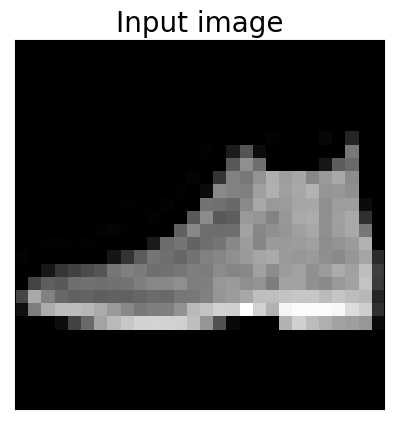

<Figure size 960x720 with 0 Axes>

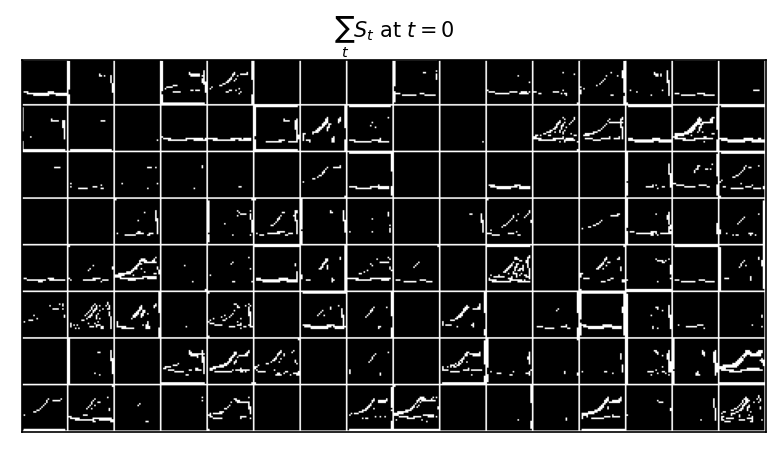

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

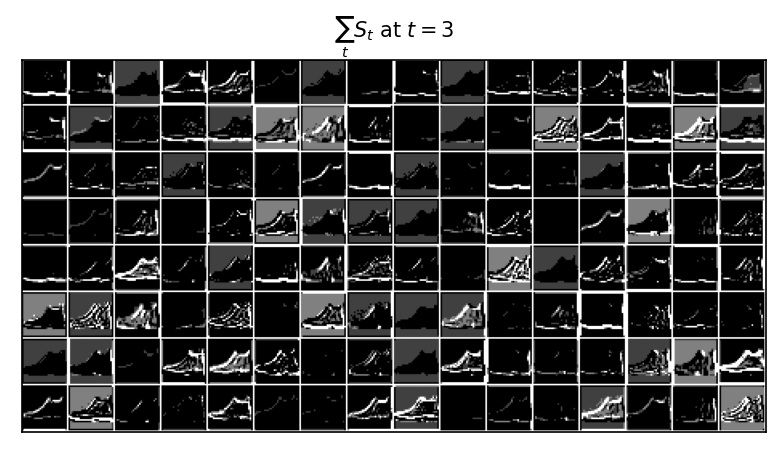

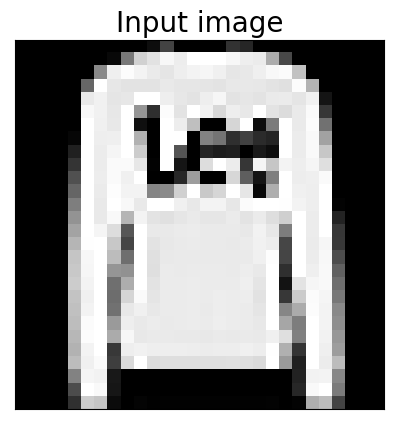

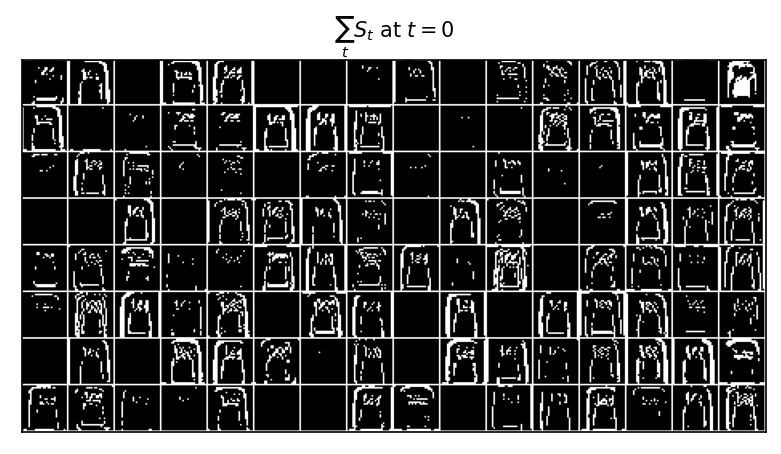

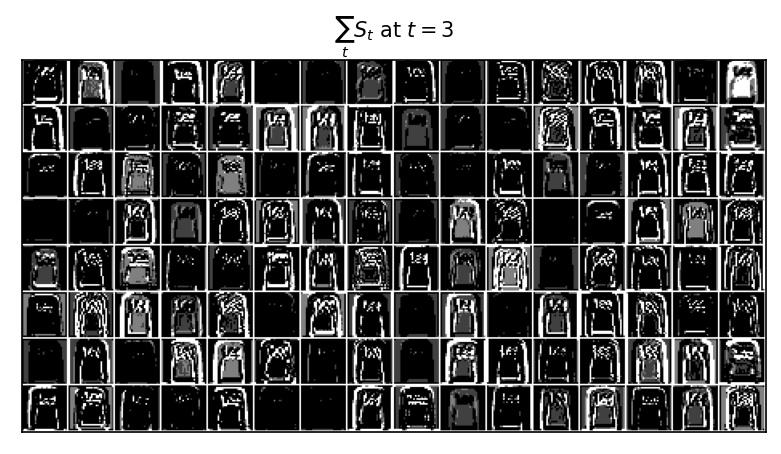

In [145]:
encoder = nn.Sequential(
    net.static_conv,
    net.conv[0]
)

encoder.to(DEVICE)
encoder.eval()

test_loader_fashion_one_batch = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)

# we will use this to make a gif of the outputs over the simulation steps
plots = []

with torch.no_grad():
    for idx, (img, label) in enumerate(test_loader_fashion_one_batch):

        # we have to reset the neurons membrane's potentials before each inference!
        # else it would keep information from the previous run.
        # You can comment this line and see what happens!
        functional.reset_net(encoder)

        fig = plt.figure(dpi=100)
        plt.imshow(img.squeeze().numpy(), cmap='gray')
        # Note that the size of the image input to the network is ``[1, 1, 28, 28]``, the 0th dimension is ``batch``, and the first dimension is ``channel``
        # therefore, when calling ``imshow``, first use ``squeeze()`` to change the size to ``[28, 28]``
        plt.title('Input image', fontsize=20)
        plt.xticks([])
        plt.yticks([])
        plt.show()

        out_spikes = 0
        for t in range(net.T):
            one_out_spike = encoder(img.to(DEVICE)).squeeze()
            out_spikes += one_out_spike
            # the size of encoder(img) is ``[1, 128, 28, 28]``，the same use ``squeeze()`` transform size to ``[128, 28, 28]``

            if idx==0:
                fig, _ = visualizing.plot_2d_spiking_feature_map(one_out_spike.cpu(), 8, 16, 1, None, dpi=150)
                # plots.append(fig)
                fig.savefig(f"./gifs/plot_{t}.png")
                plt.clf()

            if t == 0 or t == net.T - 1:
                out_spikes_c = out_spikes.clone()
                
                if t == net.T - 1: 
                    # this line is here to take the average of the output layer over the simulation steps
                    # This is how the encoder encodes data.
                    out_spikes_c /= t+1

                visualizing.plot_2d_spiking_feature_map(out_spikes_c.cpu(), 8, 16, 1, None, dpi=150)
                plt.title('$\\sum_{t} S_{t}$ at $t = ' + str(t) + '$', fontsize=10)
                plt.show()
        if idx >= 1:
            break


The encoder does a pretty good job on both inputs!
<br>Let's see the encoder activation at each specific step of the simulation:

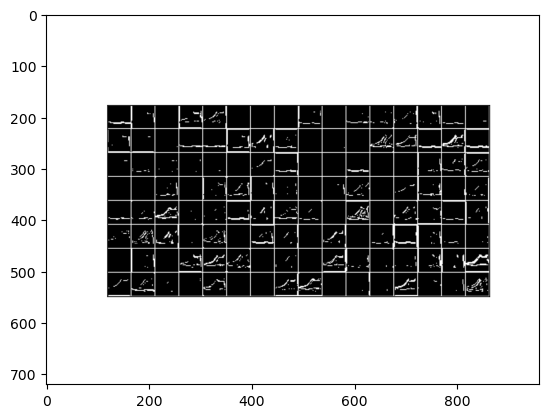

In [142]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def update(frame_number):
    image = plt.imread(f"./gifs/plot_{frame_number}.png")
    plt.imshow(image)

fig = plt.figure()
anim = animation.FuncAnimation(fig, update, frames=4, interval=500)

HTML(anim.to_jshtml())


Here you can see how the SNN layer encodes the image. The result you got earlier at the last step t=4 was the sum of all the images! We can get it back this way

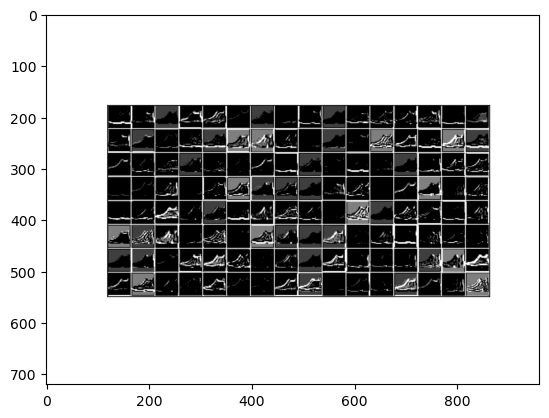

In [134]:
summed_image = sum([plt.imread(f"./gifs/plot_{frame_number}.png") for frame_number in range(4)]) / 4
plt.imshow(summed_image)

## Deep residual learning

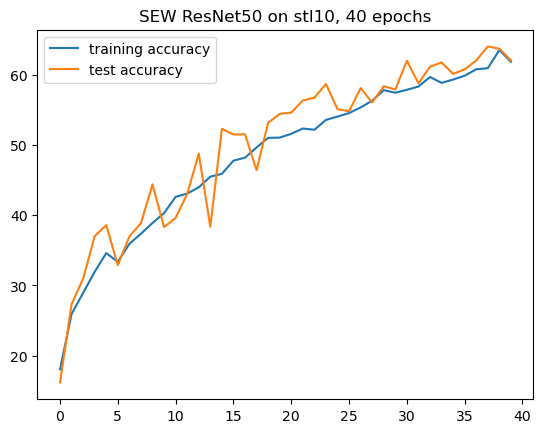

In [13]:
sew_resnet_train_accuracies = [18.04, 25.919999999999998, 28.939999999999998, 31.94, 34.599999999999994, 33.36, 35.92, 37.36, 38.9, 40.300000000000004, 42.620000000000005, 43.08, 43.980000000000004, 45.5, 45.9, 47.78, 48.199999999999996, 49.66, 51.019999999999996, 51.06, 51.6, 52.35999999999999, 52.18000000000001, 53.580000000000005, 54.059999999999995, 54.559999999999995, 55.36, 56.32, 57.82000000000001, 57.46, 57.879999999999995, 58.34, 59.699999999999996, 58.86, 59.34, 59.88, 60.8, 60.96, 63.54, 61.88]
sew_resnet_test_accuracies = [16.162499999999998, 27.3125, 30.975, 37.025000000000006, 38.6, 32.875, 36.975, 38.875, 44.4, 38.3, 39.6125, 43.025000000000006, 48.775, 38.3625, 52.31249999999999, 51.5, 51.5375, 46.4125, 53.175, 54.43750000000001, 54.625, 56.35, 56.75, 58.7125, 55.1125, 54.825, 58.1125, 56.0875, 58.3875, 57.925000000000004, 62.0125, 58.8, 61.175000000000004, 61.762499999999996, 60.150000000000006, 60.78750000000001, 62.050000000000004, 64.05, 63.737500000000004, 62.0625]

plt.plot(range(len(sew_resnet_train_accuracies)), sew_resnet_train_accuracies, label="training accuracy")
plt.plot(range(len(sew_resnet_train_accuracies)), sew_resnet_test_accuracies, label="test accuracy")
plt.title('SEW ResNet50 on stl10, 40 epochs')
plt.legend()
plt.show()

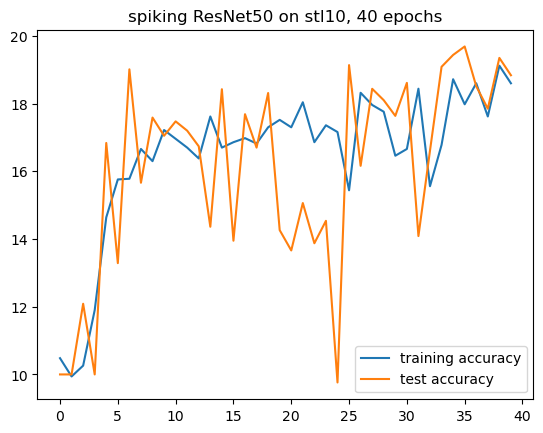

In [12]:
spiking_resnet_train_acc = [10.48, 9.94, 10.26, 11.899999999999999, 14.64, 15.76, 15.78, 16.66, 16.3, 17.22, 16.96, 16.7, 16.38, 17.62, 16.7, 16.86, 16.98, 16.82, 17.299999999999997, 17.52, 17.299999999999997, 18.04, 16.86, 17.36, 17.16, 15.440000000000001, 18.32, 17.96, 17.76, 16.46, 16.66, 18.44, 15.559999999999999, 16.78, 18.72, 17.98, 18.6, 17.62, 19.12, 18.6]
spiking_resnet_test_acc = [10.0, 10.0, 12.0875, 10.0, 16.8375, 13.2875, 19.0125, 15.662499999999998, 17.5875, 17.05, 17.474999999999998, 17.2, 16.7375, 14.3625, 18.425, 13.950000000000001, 17.6875, 16.7, 18.3125, 14.2625, 13.6625, 15.0625, 13.875000000000002, 14.5375, 9.762500000000001, 19.1375, 16.162499999999998, 18.4375, 18.099999999999998, 17.6375, 18.6125, 14.0875, 16.6125, 19.0875, 19.4375, 19.6875, 18.512500000000003, 17.849999999999998, 19.35, 18.8375]

plt.plot(range(len(spiking_resnet_train_acc)), spiking_resnet_train_acc, label="training accuracy")
plt.plot(range(len(spiking_resnet_train_acc)), spiking_resnet_test_acc, label="test accuracy")
plt.title(f"spiking ResNet50 on stl10, 40 epochs")
plt.legend()
plt.show()

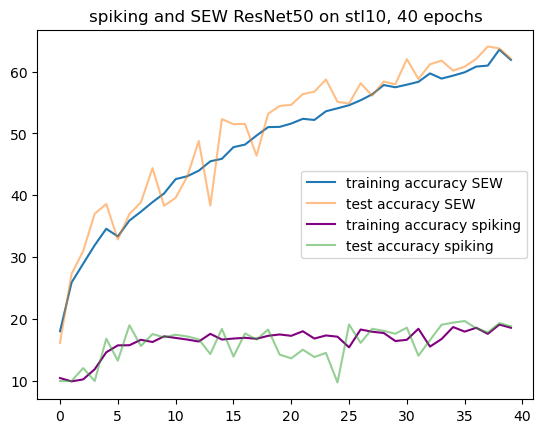

In [17]:
plt.plot(range(len(sew_resnet_train_accuracies)), sew_resnet_train_accuracies, label="training accuracy SEW")
plt.plot(range(len(sew_resnet_train_accuracies)), sew_resnet_test_accuracies, label="test accuracy SEW", alpha=0.5)


plt.plot(range(len(spiking_resnet_train_acc)), spiking_resnet_train_acc, label="training accuracy spiking", c='purple')
plt.plot(range(len(spiking_resnet_train_acc)), spiking_resnet_test_acc, label="test accuracy spiking", alpha=0.5)

plt.title(f"spiking and SEW ResNet50 on stl10, 40 epochs")
plt.legend()
plt.show()